In [103]:
import os
import sys
from pathlib import Path

import cv2 as cv
import cv2
import h5py
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [104]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [105]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
experiment = "tonsil"
core = "DonorA"
# experiment = "endometrium"
# core = "L11"
experiment = "Lung"
core = "B5"
datasets = [f'{core}_{i}' for i in range(1,7)]

In [107]:
import pySPM

TOF = pySPM.ITA((p_dir / "data" / 'imzml' / "DonorA_1_0.ita"))
TOF.show_masses()

0: (total) [] 0.00u - 882.62u (center: 441.31u)
1: (sum of rest) [] 0.00u - 882.62u (center: 441.31u)
2: () [H-] 1.01u - 1.01u (center: 1.01u)
3: () [O-] 16.00u - 16.20u (center: 16.11u)
4: () [OH-] 17.02u - 17.21u (center: 17.12u)
5: () [] 30.04u - 30.36u (center: 30.18u)
6: () [] 34.01u - 34.35u (center: 34.18u)
7: () [Cl-] 34.93u - 35.37u (center: 35.11u)
8: () [] 41.97u - 42.44u (center: 42.22u)
9: () [] 44.06u - 44.46u (center: 44.28u)
10: () [C_3N-] 49.97u - 50.51u (center: 50.28u)
11: () [] 55.04u - 55.49u (center: 55.34u)
12: () [] 56.04u - 56.49u (center: 56.32u)
13: () [] 57.04u - 57.50u (center: 57.22u)
14: () [] 58.04u - 58.50u (center: 58.28u)
15: () [] 59.05u - 59.51u (center: 59.28u)
16: () [] 60.05u - 60.52u (center: 60.27u)
17: () [] 61.05u - 61.53u (center: 61.34u)
18: (Acyl chain) [C_5H_9-] 62.96u - 63.50u (center: 63.26u)
19: () [] 64.01u - 64.57u (center: 64.27u)
20: () [C_3H_2N_2-] 66.06u - 66.61u (center: 66.27u)
21: () [] 67.07u - 67.57u (center: 67.33u)
22: () 

In [108]:
masses_dict = TOF.get_masses()
masses = [v['cmass'] for v in masses_dict][2:-2]
masses.pop(158)

327.8573625437915

In [109]:
df = pd.concat([pd.DataFrame(labels[2:]), pd.DataFrame(masses)], axis=1)

In [110]:
# df.to_csv('test.csv')

In [111]:
from functools import partial

h5_data_dir = p_dir / "data" / "h5"

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels

In [112]:
imzML_path = p_dir / "data" / 'imzml2'
imzML_path.mkdir(exist_ok=True)

In [113]:
# from pyimzml.ImzMLParser import ImzMLParser

# p = ImzMLParser(imzML_path / 'Example_Processed.imzML')
# my_spectra = []
# for idx, (x,y,z) in enumerate(p.coordinates):
#     mzs, intensities = p.getspectrum(idx)
#     my_spectra.append([mzs, intensities, (x, y, z)])

In [114]:
# masses_auto = [1.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.7, 21.7, 22.6, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 181.0, 182.0, 183.0, 184.9, 186.0, 187.0, 188.0, 189.0, 192.0, 193.9, 195.9, 197.0, 198.9, 200.9, 204.9, 208.9, 210.0, 216.9, 221.9, 228.9, 233.9, 237.9, 242.9, 253.3, 277.0, 325.2, 328.9, 343.8]

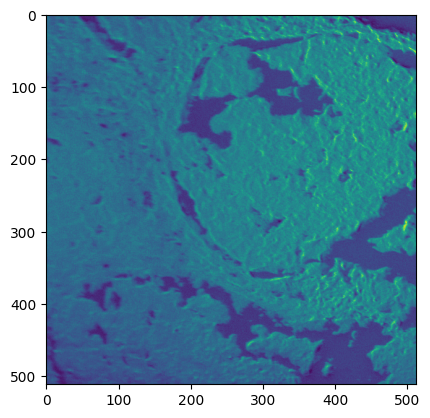

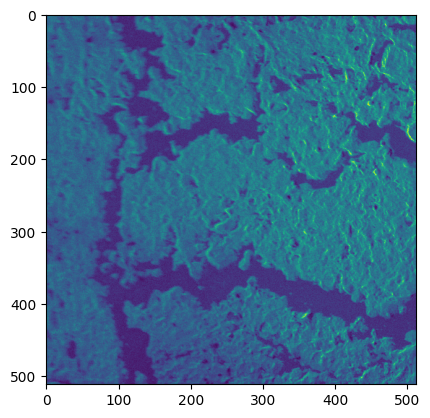

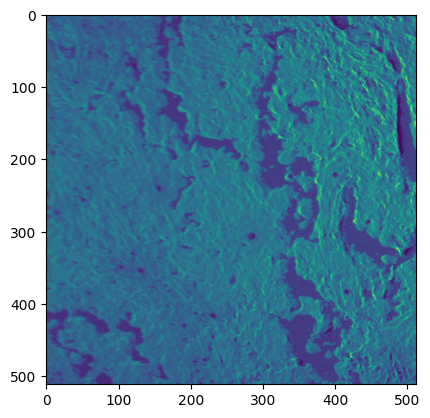

In [115]:
from pyimzml.ImzMLWriter import ImzMLWriter

for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
     # --- Read tof-sims images
    imgs, labels = get_imgs_sims(experiment, dataset)
    plt.imshow(imgs[0])
    plt.show()
    my_spectra = []
    for x in range(imgs.shape[1]):
        for y in range(imgs.shape[2]):
            my_spectra.append([masses, imgs[2:, x, y], (x+1, y+1, 1)])
            
    with ImzMLWriter(imzML_path / f'{dataset}.imzML', polarity='negative') as w:
        for mzs, intensities, coords in my_spectra:
             w.addSpectrum(mzs, intensities, coords)

In [116]:
from pyimzml.ImzMLParser import ImzMLParser

p = ImzMLParser(imzML_path / f'{datasets[1]}.imzML')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

In [117]:
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    print(len(mzs), len(intensities))
    break

189 189
